The following code runs the classification experiment from the Hitchhikers-guide tutorial modified to vectorize the job descriptions using doc2vec.

In [ ]:
%pylab inline 
import nltk
import json
import re
import time
import pandas as pd
from __future__ import print_function
from six.moves import zip, range 

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter

from gensim import models
import warnings

nltk.download('stopwords')

In [7]:
warnings.filterwarnings('ignore')

In [9]:
df_jobs_data = pd.read_csv('./jobs_subset.csv')

In [10]:
df_jobs_data.normalizedTitle_onetName.unique()

array(['Lawyers', 'Software Quality Assurance Engineers and Testers',
       'Graduate Teaching Assistants', 'Financial Examiners',
       'Credit Analysts'], dtype=object)

In [11]:
df_train = pd.read_csv('./train_corpus_document_tagging.csv')
df_test = pd.read_csv('./test_corpus_document_tagging.csv')

In [12]:
df_train.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,96011,Credit Analysts,/Join a financial group thats as committed to ...
1,355594,Credit Analysts,"for fastest consideration on this position, pl..."
2,118598,Credit Analysts,As a Credit Analyst youll be responsible for c...
3,107794,Credit Analysts,We are a specialty retailer offering the very ...
4,40010,Credit Analysts,Title: KYC Remediation Team Analyst II Locatio...


In [13]:
df_test.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,356466,Credit Analysts,Collections Analyst to monitor and follow up o...
1,314705,Credit Analysts,"Credit Analyst **Location:** LAVERGNE, TN **Sa..."
2,84895,Credit Analysts,Deputy Head of Credit/Senior Credit Officer - ...
3,194749,Credit Analysts,Dresden Partners cuenta con 10 anos de experie...
4,351689,Credit Analysts,Degreed accountant with manufacturing experien...


## Process data

In [14]:
RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters

test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.jobDescription.values])
train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.jobDescription.values])

test_labels = df_test.normalizedTitle_onetName.values
train_labels = df_train.normalizedTitle_onetName.values

In [15]:
labels = np.append(train_labels, test_labels)
corpus = np.append(train_corpus,test_corpus)

In [16]:
#Function to return processed corpus from input 
def GetProcessedCorpus(d): 
    processed_corpus= list()
    for i in range(len(d)):
        d1 = d[i].split()
        processed_corpus.append(d1)
    return processed_corpus

In [17]:
class LabeledLineSentence(object):
        def __init__(self, documents_list, labels_list):
            self.labels_list = labels_list
            self.documents_list = documents_list
        def __iter__(self):
            for idx, doc in enumerate(self.documents_list):
                yield models.doc2vec.LabeledSentence(doc,[self.labels_list[idx]])

In [18]:
def Use_Doc2Vec(train_corpus,test_corpus):
    test_labels = np.array(['Test{}'.format(i) for i in range(len(test_corpus))])
    train_labels = np.array(['Train{}'.format(i) for i in range(len(train_corpus))])
    LabelledSentence_train = LabeledLineSentence(train_corpus, train_labels)  
    LabelledSentence_test =  LabeledLineSentence(test_corpus, test_labels)
    
    model_train = models.Doc2Vec( min_count = 1, workers = 11
                                 ,alpha = 0.025, min_alpha = 0.025) 
   
    model_test  = models.Doc2Vec( min_count = 1, workers = 11
                                 ,alpha = 0.025, min_alpha = 0.025) 
    model_train.build_vocab(LabelledSentence_train)
    model_test.build_vocab(LabelledSentence_test)
    
    print("Training...")
    for epoch in range(10):
        model_train.train(LabelledSentence_train, total_examples = model_train.corpus_count, epochs = model_train.iter)
        model_train.alpha -= 0.002
        model_train.min_alpha = model_train.alpha
        
    for epoch in range(10):
        model_test.train(LabelledSentence_test, total_examples = model_test.corpus_count, epochs = model_test.iter)
        model_test.alpha -= 0.002
        model_test.min_alpha = model_test.alpha
    
    print("Training Done!")
    model_train.save("train_model.doc2vec")
    doc2vec_train_model = models.doc2vec.Doc2Vec.load('train_model.doc2vec')
    model_test.save("test_model.doc2vec")
    
    doc2vec_test_model = models.doc2vec.Doc2Vec.load('test_model.doc2vec')
    
    train_set = numpy.zeros((model_train.docvecs.count, 100))
    for i in range(model_train.docvecs.count):
        train_set[i] = model_train.docvecs[i]
    test_set = numpy.zeros((model_test.docvecs.count, 100))
    for i in range(model_test.docvecs.count):
        test_set[i] = model_test.docvecs[i]
        
    return train_set, test_set


In [19]:
processed_train_corpus = GetProcessedCorpus(train_corpus)
processed_test_corpus  = GetProcessedCorpus(test_corpus)

training_vector,test_vector = Use_Doc2Vec(processed_train_corpus,processed_test_corpus)

Training...
Training Done!


In [20]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(labels)
labels_binary = le.transform(labels)

In [21]:
labels_binary

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [22]:
labels[:10]

array(['Credit Analysts', 'Credit Analysts', 'Credit Analysts',
       'Credit Analysts', 'Credit Analysts', 'Credit Analysts',
       'Credit Analysts', 'Credit Analysts', 'Credit Analysts',
       'Credit Analysts'], dtype=object)

In [23]:
train_set_index = np.arange(0,df_train.shape[0])
test_set_index = np.arange(df_train.shape[0], len(labels))
train_labels_binary = labels_binary[train_set_index]
test_labels_binary = labels_binary[test_set_index]

In [25]:
clf = LogisticRegression(penalty='l1')
mdl = clf.fit(training_vector,
              labels_binary[train_set_index]) 
y_score = mdl.predict_proba( test_vector ) 

## Evaluation

In [26]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

<Figure size 432x288 with 0 Axes>

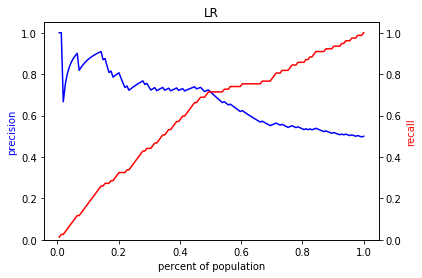

In [27]:
plot_precision_recall_n(labels_binary[test_set_index], y_score[:,1], 'LR')

In [28]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.721332


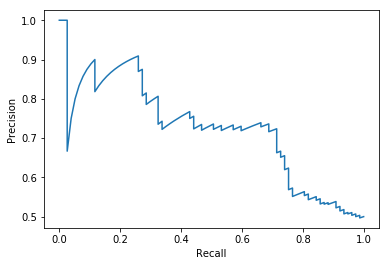

<Figure size 432x288 with 0 Axes>

In [29]:
plot_precision_recall(labels_binary[test_set_index],y_score)

## Cross Validation

In [31]:
auc_sum = 0

Training...
Training Done!
Training...
Training Done!
Training...
Training Done!
Training...
Training Done!
Training...
Training Done!
Average AUC 0.7314484135224003


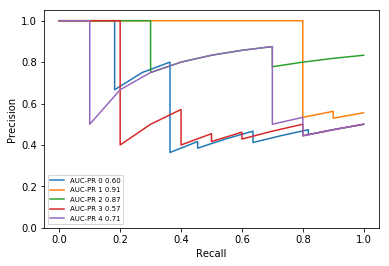

In [32]:
from sklearn.cross_validation import StratifiedKFold
cv = StratifiedKFold(train_labels_binary, n_folds=5)
train_labels_binary = le.transform(train_labels)
for i, (train,test) in enumerate(cv):
    cv_train = train_corpus[train]
    cv_test = train_corpus[test]
    doc2vec_train, doc2vec_test = Use_Doc2Vec(GetProcessedCorpus(cv_train),GetProcessedCorpus(cv_test))
    probas_ = clf.fit(doc2vec_train, 
                      train_labels_binary[train]).predict_proba(doc2vec_test)
    cv_test_labels = train_labels_binary[test]
    
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(cv_test_labels,
                                                                          probas_[:,1])
    auc_val = auc(recall_curve,precision_curve)
    auc_sum = auc_sum + auc_val
    #print(auc_sum)
    plt.plot(recall_curve, precision_curve, label='AUC-PR {0} {1:.2f}'.format(i,auc_val))
    
    
plt.ylim(0,1.05)    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize='x-small')
print("Average AUC", auc_sum/5) #as number of folds = 5

## Examples of Tagging

In [33]:
num_comments = 5
label0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
label1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression


#convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([label0_comment_idx, 
                                               label1_comment_idx])

In [34]:
test_set_labels = labels[test_set_index]

In [35]:
#these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_set_labels[i],
                                          y_score[i,1],
                                          test_corpus[i]))

Financial Examiners:1.3587428773835403e-06
---
 general responsibilities the compliance analyst iii is responsible for advanced monitoring analysis investigation of transactional data for identification of patterns and trends of questionable and or suspicious activity as it relates to risks associated with violations money laundering fraud terrorist financing corruption and sanctions lists the incumbent is responsible for gathering the proper documentation investigating potentially suspicious financial activity writing details reports summarizing research results and when appropriate files suspicious activity reports sars with country regulatory bodies refers matters to the regional compliance teams for review and reporting conducting an investigation may involve written and verbal communications with agents customers law enforcement and moneygram employees primary responsibilities o evaluates fraudulent suspicious and or unusual activity for regulatory reporting and or escalation to m